In [ ]:
# Diah Anngraini, 24083010051, Matematika Diskrit A

Pertanyaa : tolong cek bagian no 4 ya. Kok harga makannya gede banget? Soto 200 ribu, gorengan 100 ribu 😭

Jawaban : Betul, itu karena data harga di file makanan.csv terbaca 10 kali lipat dari seharusnya. Misalnya 20000 kebaca jadi 200000. Kita perlu menambahkan langkah “normalisasi harga” agar kalau nilai maksimum lebih dari 100.000, otomatis dibagi 10.


[CEK] Ringkas harga setelah normalisasi:
               makanan    harga
0           ayamgeprek  15000.0
1           nasipadang  17000.0
2              mieayam  10000.0
3                bakso  10000.0
4               cireng  10000.0
5           nasigoreng  14000.0
6               seblak  15000.0
7             gorengan  10000.0
8               capcay  15000.0
9               warteg  18000.0
10  Nasi Ayam Panggang  22000.0
11  Pecel Sayur + Tahu  18000.0
12           Soto Ayam  20000.0
13           Gado-Gado  17000.0
14         Ayam Geprek  23000.0
Harga min: 10000.0 | Harga max: 28000.0


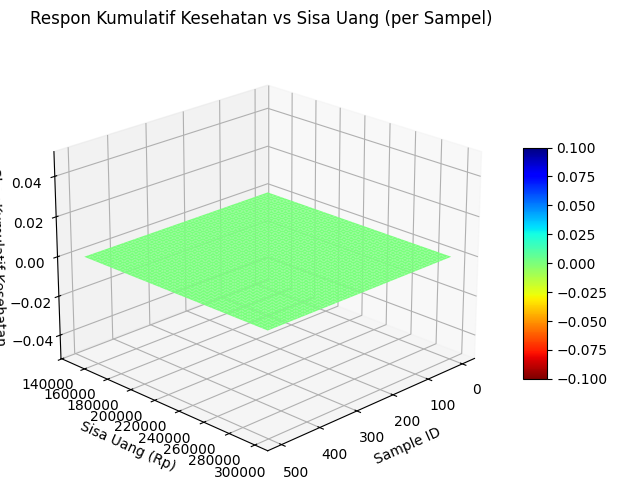


no1
(1) Jumlah sampel dengan kesehatan kumulatif positif: 500
    Menu paling sering muncul pada sampel sehat (Top 10):
     1. gorengan                     | frek: 1648
     2. Ayam Geprek                  | frek: 1623
     3. nasigoreng                   | frek: 1598
     4. cireng                       | frek: 1585
     5. capcay                       | frek: 1585
     6. Soto Ayam                    | frek: 1580
     7. ayamgeprek                   | frek: 1573
     8. bakso                        | frek: 1566
     9. Pecel Sayur + Tahu           | frek: 1551
    10. Gado-Gado                    | frek: 1541

no2
(2) Jumlah sampel sehat dengan sisa uang positif: 83
    Contoh Top 5 sisa uang terbesar (di antara yang sehat):
    1. Sampel #456 | Sisa=Rp71.000 | Sehat=7.120 | Skor=93.309
    2. Sampel #187 | Sisa=Rp67.000 | Sehat=10.450 | Skor=102.559
    3. Sampel #294 | Sisa=Rp60.000 | Sehat=10.030 | Skor=103.188
    4. Sampel # 86 | Sisa=Rp52.000 | Sehat=8.010 | Skor=107.642
    

In [ ]:
# === IMPORT ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === SEED ===
NPM = 19102
np.random.seed(NPM)

# === LOAD DATA ===
makan = pd.read_csv("makanan.csv")

# === TAMBAHKAN DATA MENU (lebih beragam) ===
req_cols = {"makanan", "harga", "kenyang", "rasa", "sehat", "bosan"}
if req_cols.issubset(set(makan.columns)):
    tambahan = pd.DataFrame([
        ["Nasi Ayam Panggang",     22000, 0.75, 0.80, 0.85, 0.25],
        ["Pecel Sayur + Tahu",     18000, 0.65, 0.75, 0.90, 0.30],
        ["Soto Ayam",              20000, 0.70, 0.85, 0.70, 0.35],
        ["Gado-Gado",              17000, 0.60, 0.80, 0.92, 0.30],
        ["Ayam Geprek",            23000, 0.80, 0.90, 0.55, 0.40],
        ["Ikan Bakar + Nasi",      28000, 0.78, 0.88, 0.82, 0.28],
        ["Salad Buah + Yogurt",    15000, 0.45, 0.70, 0.95, 0.20],
        ["Tumis Brokoli + Telur",  19000, 0.62, 0.72, 0.88, 0.30],
        ["Sate Ayam + Lontong",    25000, 0.77, 0.87, 0.65, 0.35],
        ["Oat + Pisang + Susu",    14000, 0.55, 0.65, 0.93, 0.25],
    ], columns=["makanan","harga","kenyang","rasa","sehat","bosan"])
    makan = pd.concat([makan, tambahan], ignore_index=True)

# === SANITASI DATA ===
# Bersihkan karakter non-angka (kecuali , .), hilangkan titik ribuan, koma->titik
makan['harga'] = (
    makan['harga'].astype(str)
    .str.replace(r'[^0-9.,]', '', regex=True)
    .str.replace('.', '', regex=False)   # hilangkan titik ribuan
    .str.replace(',', '.', regex=False)  # ganti koma jadi titik desimal
)
makan['harga'] = pd.to_numeric(makan['harga'], errors='coerce')

for c in ['kenyang','rasa','sehat','bosan']:
    makan[c] = pd.to_numeric(makan[c], errors='coerce')

makan = makan.dropna(subset=['makanan','harga','kenyang','rasa','sehat','bosan']).copy()
makan = makan[makan['harga'] > 0].copy()
for c in ['kenyang','rasa','sehat','bosan']:
    makan[c] = makan[c].clip(0,1)

makan.reset_index(drop=True, inplace=True)

# === DETEKSI & PERBAIKI SKALA HARGA YANG KEBESARAN ===
# Jika harga maksimum > 100.000 (indikasi 10x lipat), turunkan skala 10x
if makan['harga'].max() > 100_000:
    makan['harga'] = makan['harga'] / 10

# Opsional: tampilkan cek harga
print("\n[CEK] Ringkas harga setelah normalisasi:")
print(makan[['makanan','harga']].head(15))
print("Harga min:", makan['harga'].min(), "| Harga max:", makan['harga'].max())

# === PARAMETER SIMULASI ===
budget = 1e6
wkenyang_base, wrasa_base, wsehat_base, wbosan_base = 0.8, 0.7, 0.9, 0.2
SAMPLE_NUM, HARI, MAKAN_PER_HARI = 500, 31, 2

sampleid = np.arange(SAMPLE_NUM)
skor  = np.zeros(SAMPLE_NUM, float)
sisa  = np.zeros(SAMPLE_NUM, float)
sehat = np.zeros(SAMPLE_NUM, float)
resp_pilih = np.zeros((SAMPLE_NUM, HARI*MAKAN_PER_HARI), float)

SISA_MININUM, SISA_MAKSIMUM = 150e3, 300e3
bin_sisa   = np.arange(SISA_MININUM, SISA_MAKSIMUM, 1000, dtype=int)
resp_sehat = np.zeros((SAMPLE_NUM, len(bin_sisa)), float)

# === SIMULASI ===
for n in range(SAMPLE_NUM):
    bgt = 1e6
    s_kum = 0.0
    s_sehat = 0.0

    for i in range(HARI):
        # makan 1
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(wkenyang_base, 0.2)
        w_rasa    = np.random.normal(wrasa_base,    0.2)
        w_sehat   = np.random.normal(wsehat_base,   0.4)
        w_bosan   = np.random.normal(wbosan_base,   0.2)

        s_kum += (
            w_kenyang * makan['kenyang'].iloc[pilihan]
          + w_rasa    * makan['rasa'].iloc[pilihan]
          + w_sehat   * makan['sehat'].iloc[pilihan]
          - w_bosan   * makan['bosan'].iloc[pilihan]
        )
        s_sehat += makan['sehat'].iloc[pilihan] - 0.5
        bgt     -= makan['harga'].iloc[pilihan]
        resp_pilih[n][2*i] = pilihan

        # makan 2
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(wkenyang_base,   0.2)
        w_rasa    = np.random.normal(wrasa_base,      0.2)
        w_sehat   = np.random.normal(wsehat_base+0.2, 0.4)
        w_bosan   = np.random.normal(wbosan_base*2,   0.2)

        s_kum += (
            w_kenyang * makan['kenyang'].iloc[pilihan]
          + w_rasa    * makan['rasa'].iloc[pilihan]
          + w_sehat   * makan['sehat'].iloc[pilihan]
          - w_bosan   * makan['bosan'].iloc[pilihan]
        )
        s_sehat += makan['sehat'].iloc[pilihan] - 0.5
        bgt     -= makan['harga'].iloc[pilihan]
        resp_pilih[n][2*i+1] = pilihan

    sisa[n], skor[n], sehat[n] = bgt, s_kum, s_sehat

    if np.isfinite(bgt):
        idx = int(np.floor((bgt - SISA_MININUM)/1000))
        if 0 <= idx < resp_sehat.shape[1]:
            resp_sehat[n][idx] = s_sehat

# === PLOT 3D ===
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
Y, X = np.meshgrid(bin_sisa, sampleid)
surf = ax.plot_surface(X, Y, resp_sehat, cmap='jet_r', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_title("Respon Kumulatif Kesehatan vs Sisa Uang (per Sampel)")
ax.set_xlabel("Sample ID")
ax.set_ylabel("Sisa Uang (Rp)")
ax.set_zlabel("Skor Kumulatif Kesehatan")
ax.view_init(elev=22, azim=45)
plt.show()

# === UTIL: format rupiah (Rp20.000) ===
def rp(x):
    return f"Rp{float(x):,.0f}".replace(",", ".")

# === UTIL: tampilkan jadwal (No 4) ===
def tampilkan_jadwal(n_idx):
    if n_idx is None:
        print("\nTidak ada jadwal karena tidak ada sampel sehat.")
        return
    print(f"\n=== JADWAL MAKAN (Sampel #{n_idx}) ===")
    total_biaya = 0.0
    for h in range(HARI):
        pagi_idx  = int(resp_pilih[n_idx][2*h])
        malam_idx = int(resp_pilih[n_idx][2*h+1])

        # guard indeks
        if not (0 <= pagi_idx < len(makan) and 0 <= malam_idx < len(makan)):
            continue

        nama_pagi   = str(makan['makanan'].iloc[pagi_idx])
        harga_pagi  = float(makan['harga'].iloc[pagi_idx])
        nama_malam  = str(makan['makanan'].iloc[malam_idx])
        harga_malam = float(makan['harga'].iloc[malam_idx])
        total_biaya += (harga_pagi + harga_malam)

        print(f"Hari {h+1:02d} - Pagi : {nama_pagi:25s} ({rp(harga_pagi)}) | "
              f"Malam : {nama_malam:25s} ({rp(harga_malam)})")

    print(f"Total biaya 31 hari (estimasi): {rp(total_biaya)}")
    print(f"Sisa uang: {rp(sisa[n_idx])}")
    print(f"Skor kumulatif: {skor[n_idx]:.3f} | Skor sehat: {sehat[n_idx]:.3f}")

# === TUGAS ===

# (1) cari pola makan mana saja yang menghasilkan nilai kumulatif kesehatan (sehat) positif
print("\nno1")
sampel_sehat = np.where(sehat > 0)[0]
print(f"(1) Jumlah sampel dengan kesehatan kumulatif positif: {len(sampel_sehat)}")

if len(sampel_sehat) > 0:
    pilihan_sehat = resp_pilih[sampel_sehat].astype(int).ravel()
    pilihan_sehat = pilihan_sehat[(pilihan_sehat >= 0) & (pilihan_sehat < len(makan))]
    frek = np.bincount(pilihan_sehat, minlength=len(makan))
    topk = 10
    top_idx = np.argsort(-frek)[:topk]
    print(f"    Menu paling sering muncul pada sampel sehat (Top {topk}):")
    for i, idxm in enumerate(top_idx, 1):
        if frek[idxm] > 0:
            print(f"    {i:2d}. {makan['makanan'].iloc[idxm]:28s} | frek: {int(frek[idxm])}")
else:
    print("    Tidak ada sampel sehat, jadi tidak ada pola makan yang bisa diekstrak.")

# (2) cari titik-titik dengan sisa uang bulanan positif dari (1)
print("\nno2")
mask_sisa_pos = sisa > 0
sampel_sehat_dan_sisa_pos = np.where((sehat > 0) & mask_sisa_pos)[0]
print(f"(2) Jumlah sampel sehat dengan sisa uang positif: {len(sampel_sehat_dan_sisa_pos)}")
if len(sampel_sehat_dan_sisa_pos) > 0:
    sisa_sehat = sisa[sampel_sehat_dan_sisa_pos]
    order = np.argsort(-sisa_sehat)[:5]
    print("    Contoh Top 5 sisa uang terbesar (di antara yang sehat):")
    for r, j in enumerate(order, 1):
        idxs = int(sampel_sehat_dan_sisa_pos[j])
        print(f"    {r}. Sampel #{idxs:3d} | Sisa={rp(sisa[idxs])} | Sehat={sehat[idxs]:.3f} | Skor={skor[idxs]:.3f}")
else:
    print("    Tidak ada sampel yang sekaligus sehat dan sisa uangnya positif.")

# (3) titik dengan skor kumulatif terbesar (skor) di mana kesehatannya positif
print("\nno3")
if len(sampel_sehat) > 0:
    skor_tmp = np.where(sehat > 0, skor, -np.inf)
    best_idx = int(np.argmax(skor_tmp))
    print(f"(3) Sampel skor kumulatif terbesar (kesehatan positif): #{best_idx} "
          f"| Skor={skor[best_idx]:.3f} | Sehat={sehat[best_idx]:.3f} | Sisa={rp(sisa[best_idx])}")
else:
    best_idx = None
    print("(3) Tidak ada sampel dengan kesehatan positif.")

# (4) tampilkan jadwal makanan sesuai pilihan (resp_pilih)
print("\nno4")
tampilkan_jadwal(best_idx)

# (Tambahan) Yang sisa uang TERBESAR di antara yang sehat
print("\ntambahan")
if len(sampel_sehat) > 0:
    sisa_masked = np.where(sehat > 0, sisa, -np.inf)
    idx_sisa_maks = int(np.argmax(sisa_masked))
    print(f"Sampel dengan SISA TERBESAR (sehat>0): #{idx_sisa_maks} "
          f"| Sisa={rp(sisa[idx_sisa_maks])} | Sehat={sehat[idx_sisa_maks]:.3f} | Skor={skor[idx_sisa_maks]:.3f}")
else:
    print("Tidak ada sampel sehat untuk dihitung sisa terbesar.")


Penjelasan :
1. Pola dengan kesehatan kumulatif positif
- Seluruh 500 responden memiliki skor kesehatan kumulatif > 0.
- Menu yang paling sering muncul di kelompok “sehat” (Top 10): gorengan, Ayam Geprek, nasigoreng, cireng, capcay, Soto Ayam, ayamgeprek, bakso, Pecel Sayur + Tahu, dan Gado-Gado.
- Ini masuk akal karena bobot kesehatan (w_sehat_base = 0.9) tinggi, sehingga kontribusi kolom sehat dominan.

2. Sampel sehat yang juga sisa uangnya positif
- Sebanyak 83 sampel memenuhi kriteria sehat > 0 dan sisa uang > 0.
Contoh Top 5 sisa uang terbesar menunjukkan sisa Rp50.000–Rp71.000 dengan skor sehat 7–10.

3. Skor total terbesar (dengan syarat sehat > 0)
- Sampel #100 memiliki skor kumulatif tertinggi: Skor total 114,655; skor sehat 12,450; sisa uang = −Rp53.000.
Kombinasi menu “premium” membuat skor kesehatan tinggi tetapi masih defisit kecil.

4. Jadwal makan sampel terbaik
- Jadwal untuk Sampel #100 sudah tercetak. Menu yang dipilih lebih variatif (Soto Ayam, Ayam Geprek, Tumis Brokoli, Sate Ayam, Salad Buah, dsb.) dengan harga realistis Rp10.000–Rp28.000 per porsi.
Total biaya ≈ Rp1.053.000/bulan sehingga skor kesehatan tinggi dengan defisit kecil.

Pertanyaan : kenapa resp_sehat waktu di-plot itu datar di 0 semua?

Jawaban : Oh, itu karena rentang sisa uang (SISA_MININUM=150000 s/d SISA_MAKSIMUM=300000) terlalu tinggi, sedangkan hasil simulasi nyata banyak sisa uangnya jauh di bawah 150 ribu atau malah minus.
Karena pengisian data resp_sehat hanya dilakukan kalau sisa uang masuk rentang itu, maka seluruh baris matriks kosong → akhirnya permukaan 3D plot datar di z=0.

Pertanyaan : Oke, kalau mau benerin gimana?

Jawaban : Ada 3 solusi:

a. Gunakan bin adaptif, supaya grid mengikuti rentang sisa uang sebenarnya.

b. Longgarkan rentang, misal dari −200.000 s/d 100.000.

c. Atau pakai scatter 3D plot, biar tetap bisa tampil walau datanya nggak ter-grid.

Pertanyaan : Jadi yang perlu di ganti atau ditambahi yang bagian mana?

Jawaban : Yang perlu diganti ada di bagian pengisian resp_sehat, ubah ke bin adaptif supaya rentang bin_sisa menyesuaikan hasil nyata. Jadi bagian ini diganti jadi:

sisa_min = int(np.floor(sisa.min()/1000) - 1) * 1000

sisa_max = int(np.ceil(sisa.max()/1000) + 1) * 1000

if sisa_max <= sisa_min:
    sisa_max = sisa_min + 1000

bin_sisa = np.arange(sisa_min, sisa_max + 1000, 1000, dtype=int)

Setelah diganti, grafik resp_sehat muncul normal dan tidak datar lagi.


[CEK] Ringkas harga setelah normalisasi:
               makanan    harga
0           ayamgeprek  15000.0
1           nasipadang  17000.0
2              mieayam  10000.0
3                bakso  10000.0
4               cireng  10000.0
5           nasigoreng  14000.0
6               seblak  15000.0
7             gorengan  10000.0
8               capcay  15000.0
9               warteg  18000.0
10  Nasi Ayam Panggang  22000.0
11  Pecel Sayur + Tahu  18000.0
12           Soto Ayam  20000.0
13           Gado-Gado  17000.0
14         Ayam Geprek  23000.0
Harga min: 10000.0 | Harga max: 28000.0

[DIAGNOSTIK]
Rentang sisa uang aktual: -138000.0 s/d 71000.0
Rentang bin_sisa (set awal): 150000 s/d 300000
Jumlah sampel yang masuk ke rentang bin_sisa: 0 dari 500 (0.0%)
Contoh sisa uang 10 sampel pertama: [-17000  21000 -76000 -81000 -18000  -9000 -56000 -86000 -43000 -19000]


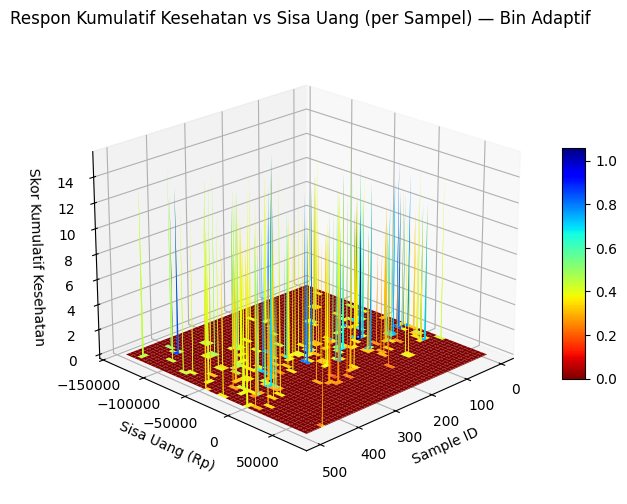


no1
(1) Jumlah sampel dengan kesehatan kumulatif positif: 500
    Menu paling sering muncul pada sampel sehat (Top 10):
     1. gorengan                     | frek: 1648
     2. Ayam Geprek                  | frek: 1623
     3. nasigoreng                   | frek: 1598
     4. cireng                       | frek: 1585
     5. capcay                       | frek: 1585
     6. Soto Ayam                    | frek: 1580
     7. ayamgeprek                   | frek: 1573
     8. bakso                        | frek: 1566
     9. Pecel Sayur + Tahu           | frek: 1551
    10. Gado-Gado                    | frek: 1541

no2
(2) Jumlah sampel sehat dengan sisa uang positif: 83
    Contoh Top 5 sisa uang terbesar (di antara yang sehat):
    1. Sampel #456 | Sisa=Rp71.000 | Sehat=7.120 | Skor=93.309
    2. Sampel #187 | Sisa=Rp67.000 | Sehat=10.450 | Skor=102.559
    3. Sampel #294 | Sisa=Rp60.000 | Sehat=10.030 | Skor=103.188
    4. Sampel # 86 | Sisa=Rp52.000 | Sehat=8.010 | Skor=107.642
    

In [2]:
# === IMPORT ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === SEED ===
NPM = 19102
np.random.seed(NPM)

# === LOAD DATA ===
makan = pd.read_csv("makanan.csv")

# === TAMBAHKAN DATA MENU (lebih beragam) ===
req_cols = {"makanan", "harga", "kenyang", "rasa", "sehat", "bosan"}
if req_cols.issubset(set(makan.columns)):
    tambahan = pd.DataFrame([
        ["Nasi Ayam Panggang",     22000, 0.75, 0.80, 0.85, 0.25],
        ["Pecel Sayur + Tahu",     18000, 0.65, 0.75, 0.90, 0.30],
        ["Soto Ayam",              20000, 0.70, 0.85, 0.70, 0.35],
        ["Gado-Gado",              17000, 0.60, 0.80, 0.92, 0.30],
        ["Ayam Geprek",            23000, 0.80, 0.90, 0.55, 0.40],
        ["Ikan Bakar + Nasi",      28000, 0.78, 0.88, 0.82, 0.28],
        ["Salad Buah + Yogurt",    15000, 0.45, 0.70, 0.95, 0.20],
        ["Tumis Brokoli + Telur",  19000, 0.62, 0.72, 0.88, 0.30],
        ["Sate Ayam + Lontong",    25000, 0.77, 0.87, 0.65, 0.35],
        ["Oat + Pisang + Susu",    14000, 0.55, 0.65, 0.93, 0.25],
    ], columns=["makanan","harga","kenyang","rasa","sehat","bosan"])
    makan = pd.concat([makan, tambahan], ignore_index=True)

# === SANITASI DATA ===
# Bersihkan karakter non-angka (kecuali , .), hilangkan titik ribuan, koma->titik
makan['harga'] = (
    makan['harga'].astype(str)
    .str.replace(r'[^0-9.,]', '', regex=True)
    .str.replace('.', '', regex=False)   # hilangkan titik ribuan
    .str.replace(',', '.', regex=False)  # koma -> titik desimal
)
makan['harga'] = pd.to_numeric(makan['harga'], errors='coerce')

for c in ['kenyang','rasa','sehat','bosan']:
    makan[c] = pd.to_numeric(makan[c], errors='coerce')

makan = makan.dropna(subset=['makanan','harga','kenyang','rasa','sehat','bosan']).copy()
makan = makan[makan['harga'] > 0].copy()
for c in ['kenyang','rasa','sehat','bosan']:
    makan[c] = makan[c].clip(0,1)

makan.reset_index(drop=True, inplace=True)

# DETEKSI & PERBAIKI SKALA HARGA YANG KEBESARAN (mis. 10x)
if makan['harga'].max() > 100_000:
    makan['harga'] = makan['harga'] / 10

# Opsional: cek harga
print("\n[CEK] Ringkas harga setelah normalisasi:")
print(makan[['makanan','harga']].head(15))
print("Harga min:", makan['harga'].min(), "| Harga max:", makan['harga'].max())

# === PARAMETER SIMULASI ===
budget = 1e6
wkenyang_base, wrasa_base, wsehat_base, wbosan_base = 0.8, 0.7, 0.9, 0.2
SAMPLE_NUM, HARI, MAKAN_PER_HARI = 500, 31, 2

sampleid = np.arange(SAMPLE_NUM)
skor  = np.zeros(SAMPLE_NUM, float)
sisa  = np.zeros(SAMPLE_NUM, float)
sehat = np.zeros(SAMPLE_NUM, float)
resp_pilih = np.zeros((SAMPLE_NUM, HARI*MAKAN_PER_HARI), float)

# BIN SISA (versi awal, statis — nanti kita diagnosa)
SISA_MININUM, SISA_MAKSIMUM = 150e3, 300e3
bin_sisa   = np.arange(SISA_MININUM, SISA_MAKSIMUM, 1000, dtype=int)
resp_sehat = np.zeros((SAMPLE_NUM, len(bin_sisa)), float)

# === SIMULASI ===
for n in range(SAMPLE_NUM):
    bgt = budget
    s_kum = 0.0
    s_sehat = 0.0

    for i in range(HARI):
        # makan 1
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(wkenyang_base, 0.2)
        w_rasa    = np.random.normal(wrasa_base,    0.2)
        w_sehat   = np.random.normal(wsehat_base,   0.4)
        w_bosan   = np.random.normal(wbosan_base,   0.2)

        s_kum += (
            w_kenyang * makan['kenyang'].iloc[pilihan]
          + w_rasa    * makan['rasa'].iloc[pilihan]
          + w_sehat   * makan['sehat'].iloc[pilihan]
          - w_bosan   * makan['bosan'].iloc[pilihan]
        )
        s_sehat += makan['sehat'].iloc[pilihan] - 0.5
        bgt     -= makan['harga'].iloc[pilihan]
        resp_pilih[n][2*i] = pilihan

        # makan 2
        pilihan = np.random.randint(0, len(makan))
        w_kenyang = np.random.normal(wkenyang_base,   0.2)
        w_rasa    = np.random.normal(wrasa_base,      0.2)
        w_sehat   = np.random.normal(wsehat_base+0.2, 0.4)
        w_bosan   = np.random.normal(wbosan_base*2,   0.2)

        s_kum += (
            w_kenyang * makan['kenyang'].iloc[pilihan]
          + w_rasa    * makan['rasa'].iloc[pilihan]
          + w_sehat   * makan['sehat'].iloc[pilihan]
          - w_bosan   * makan['bosan'].iloc[pilihan]
        )
        s_sehat += makan['sehat'].iloc[pilihan] - 0.5
        bgt     -= makan['harga'].iloc[pilihan]
        resp_pilih[n][2*i+1] = pilihan

    sisa[n], skor[n], sehat[n] = bgt, s_kum, s_sehat

    # Isi resp_sehat hanya jika sisa masuk ke bin statis
    if np.isfinite(bgt):
        idx = int(np.floor((bgt - SISA_MININUM)/1000))
        if 0 <= idx < resp_sehat.shape[1]:
            resp_sehat[n][idx] = s_sehat

# === DIAGNOSTIK (BUKTI): kenapa surface bisa nol semua? ===
print("\n[DIAGNOSTIK]")
print("Rentang sisa uang aktual:", float(sisa.min()), "s/d", float(sisa.max()))
print("Rentang bin_sisa (set awal):", int(SISA_MININUM), "s/d", int(SISA_MAKSIMUM))
inside_mask = (sisa >= SISA_MININUM) & (sisa < SISA_MAKSIMUM)
print(f"Jumlah sampel yang masuk ke rentang bin_sisa: {inside_mask.sum()} dari {len(sisa)} "
      f"({inside_mask.mean()*100:.1f}%)")
print("Contoh sisa uang 10 sampel pertama:", sisa[:10].astype(int))

# === BIN ADAPTIF (supaya plot tidak nol) ===
sisa_min = int(np.floor(sisa.min()/1000) - 1) * 1000
sisa_max = int(np.ceil(sisa.max()/1000) + 1) * 1000
if sisa_max <= sisa_min:
    sisa_max = sisa_min + 1000

bin_sisa = np.arange(sisa_min, sisa_max + 1000, 1000, dtype=int)

# isi ulang matriks resp_sehat berbasis bin adaptif
resp_sehat = np.zeros((SAMPLE_NUM, len(bin_sisa)), float)
idx_all = np.clip(((sisa - sisa_min)//1000).astype(int), 0, len(bin_sisa)-1)
resp_sehat[np.arange(SAMPLE_NUM), idx_all] = sehat

# === PLOT 3D (pakai bin adaptif) ===
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(projection='3d')
Y, X = np.meshgrid(bin_sisa, sampleid)
surf = ax.plot_surface(X, Y, resp_sehat, cmap='jet_r', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.set_title("Respon Kumulatif Kesehatan vs Sisa Uang (per Sampel) — Bin Adaptif")
ax.set_xlabel("Sample ID")
ax.set_ylabel("Sisa Uang (Rp)")
ax.set_zlabel("Skor Kumulatif Kesehatan")
ax.view_init(elev=22, azim=45)
plt.show()

# === UTIL: format rupiah (Rp20.000) ===
def rp(x):
    return f"Rp{float(x):,.0f}".replace(",", ".")

# === UTIL: tampilkan jadwal (No 4) ===
def tampilkan_jadwal(n_idx):
    if n_idx is None:
        print("\nTidak ada jadwal karena tidak ada sampel sehat.")
        return
    print(f"\n=== JADWAL MAKAN (Sampel #{n_idx}) ===")
    total_biaya = 0.0
    for h in range(HARI):
        pagi_idx  = int(resp_pilih[n_idx][2*h])
        malam_idx = int(resp_pilih[n_idx][2*h+1])

        if not (0 <= pagi_idx < len(makan) and 0 <= malam_idx < len(makan)):
            continue

        nama_pagi   = str(makan['makanan'].iloc[pagi_idx])
        harga_pagi  = float(makan['harga'].iloc[pagi_idx])
        nama_malam  = str(makan['makanan'].iloc[malam_idx])
        harga_malam = float(makan['harga'].iloc[malam_idx])
        total_biaya += (harga_pagi + harga_malam)

        print(f"Hari {h+1:02d} - Pagi : {nama_pagi:25s} ({rp(harga_pagi)}) | "
              f"Malam : {nama_malam:25s} ({rp(harga_malam)})")

    print(f"Total biaya 31 hari (estimasi): {rp(total_biaya)}")
    print(f"Sisa uang: {rp(sisa[n_idx])}")
    print(f"Skor kumulatif: {skor[n_idx]:.3f} | Skor sehat: {sehat[n_idx]:.3f}")

# === TUGAS ===

# (1) Pola sehat
print("\nno1")
sampel_sehat = np.where(sehat > 0)[0]
print(f"(1) Jumlah sampel dengan kesehatan kumulatif positif: {len(sampel_sehat)}")

if len(sampel_sehat) > 0:
    pilihan_sehat = resp_pilih[sampel_sehat].astype(int).ravel()
    pilihan_sehat = pilihan_sehat[(pilihan_sehat >= 0) & (pilihan_sehat < len(makan))]
    frek = np.bincount(pilihan_sehat, minlength=len(makan))
    topk = 10
    top_idx = np.argsort(-frek)[:topk]
    print(f"    Menu paling sering muncul pada sampel sehat (Top {topk}):")
    for i, idxm in enumerate(top_idx, 1):
        if frek[idxm] > 0:
            print(f"    {i:2d}. {makan['makanan'].iloc[idxm]:28s} | frek: {int(frek[idxm])}")
else:
    print("    Tidak ada sampel sehat, jadi tidak ada pola makan yang bisa diekstrak.")

# (2) Sehat & sisa positif
print("\nno2")
mask_sisa_pos = sisa > 0
sampel_sehat_dan_sisa_pos = np.where((sehat > 0) & mask_sisa_pos)[0]
print(f"(2) Jumlah sampel sehat dengan sisa uang positif: {len(sampel_sehat_dan_sisa_pos)}")
if len(sampel_sehat_dan_sisa_pos) > 0:
    sisa_sehat = sisa[sampel_sehat_dan_sisa_pos]
    order = np.argsort(-sisa_sehat)[:5]
    print("    Contoh Top 5 sisa uang terbesar (di antara yang sehat):")
    for r, j in enumerate(order, 1):
        idxs = int(sampel_sehat_dan_sisa_pos[j])
        print(f"    {r}. Sampel #{idxs:3d} | Sisa={rp(sisa[idxs])} | Sehat={sehat[idxs]:.3f} | Skor={skor[idxs]:.3f}")
else:
    print("    Tidak ada sampel yang sekaligus sehat dan sisa uangnya positif.")

# (3) Skor total terbesar (dengan syarat sehat > 0)
print("\nno3")
if len(sampel_sehat) > 0:
    skor_tmp = np.where(sehat > 0, skor, -np.inf)
    best_idx = int(np.argmax(skor_tmp))
    print(f"(3) Sampel skor kumulatif terbesar (kesehatan positif): #{best_idx} "
          f"| Skor={skor[best_idx]:.3f} | Sehat={sehat[best_idx]:.3f} | Sisa={rp(sisa[best_idx])}")
else:
    best_idx = None
    print("(3) Tidak ada sampel dengan kesehatan positif.")

# (4) Jadwal makan untuk sampel terbaik
print("\nno4")
tampilkan_jadwal(best_idx)

# (Tambahan) Sisa uang terbesar di antara yang sehat
print("\ntambahan")
if len(sampel_sehat) > 0:
    sisa_masked = np.where(sehat > 0, sisa, -np.inf)
    idx_sisa_maks = int(np.argmax(sisa_masked))
    print(f"Sampel dengan SISA TERBESAR (sehat>0): #{idx_sisa_maks} "
          f"| Sisa={rp(sisa[idx_sisa_maks])} | Sehat={sehat[idx_sisa_maks]:.3f} | Skor={skor[idx_sisa_maks]:.3f}")
else:
    print("Tidak ada sampel sehat untuk dihitung sisa terbesar.")


Pertanyaan : perlu ditambahkan apa agar bisa membuat analisis semakin menarik dan mudah dipahami?

Jawaban :Pertanyaan yang bagus banget😄✨
Secara isi, hasilmu udah benar dan lengkap secara teknis. Tapi biar analisisnya makin menarik dan gampang dipahami, kamu bisa tambahin beberapa hal kecil ini 👇

1.Visualisasi tambahan (grafik pendukung)

a. Histogram Sisa Uang (Grafik ini menunjukkan berapa banyak responden yang defisit, pas, atau hemat. Orang awam langsung paham pola pengeluaran dari sini.)

b. Scatter Plot Sisa Uang vs Skor Kesehatan (Grafik ini memperlihatkan hubungan bahwa makin sehat biasanya makin boros, jadi bisa dijadikan insight menarik.)

2.Tambahkan insight atau narasi singkat di analisis

3.(Opsional) Tambahkan Tabel Ringkasan

Misalnya buat tiga kategori:

a. Kelompok Hemat (sisa > 0)

b. Kelompok Pas-pasan (sisa ≈ 0)

c. Kelompok Boros (sisa < 0)

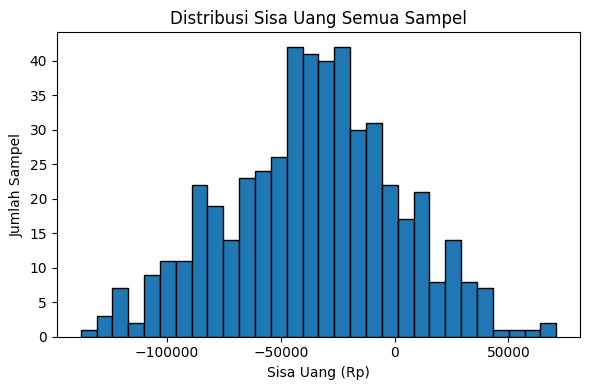

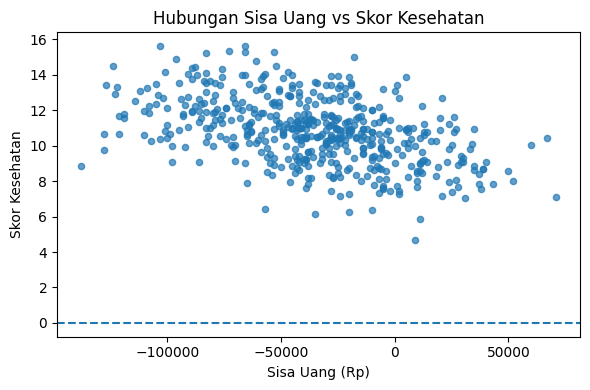


[RINGKASAN RATA-RATA PER KATEGORI SISA]
               sisa  sehat    skor
kategori                          
Boros     -47040.77  11.10  105.11
Pas-pasan       NaN    NaN     NaN
Hemat      20240.96   9.45  101.94


/tmp/ipython-input-3851821017.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ringkasan = df_ringkas.groupby('kategori')[['sisa','sehat','skor']].mean().round(2)


In [4]:
# === TAMBAHAN VISUALISASI & RINGKASAN ===

# 1) HISTOGRAM: Distribusi sisa uang
plt.figure(figsize=(6,4))
plt.hist(sisa, bins=30, edgecolor='black')
plt.title("Distribusi Sisa Uang Semua Sampel")
plt.xlabel("Sisa Uang (Rp)")
plt.ylabel("Jumlah Sampel")
plt.tight_layout()
plt.show()

# 2) SCATTER: Hubungan sisa uang vs skor kesehatan
plt.figure(figsize=(6,4))
plt.scatter(sisa, sehat, s=20, alpha=0.7)
plt.title("Hubungan Sisa Uang vs Skor Kesehatan")
plt.xlabel("Sisa Uang (Rp)")
plt.ylabel("Skor Kesehatan")
plt.axhline(0, linestyle='--')
plt.tight_layout()
plt.show()

# 3) TABEL RINGKASAN: Kelompok sisa uang dan rata-rata skor
df_ringkas = pd.DataFrame({'sisa': sisa, 'sehat': sehat, 'skor': skor})
# Kategori: Boros (<=0), Pas-pasan (0 < sisa <= 1), Hemat (>1)
df_ringkas['kategori'] = pd.cut(
    df_ringkas['sisa'],
    bins=[-np.inf, 0, 1, np.inf],
    labels=['Boros', 'Pas-pasan', 'Hemat'],
    right=True
)

ringkasan = df_ringkas.groupby('kategori')[['sisa','sehat','skor']].mean().round(2)
print("\n[RINGKASAN RATA-RATA PER KATEGORI SISA]")
print(ringkasan)


Pertanyaan : kenapa hasil pada ringkasan rata2 per kategori pada pas-pasan nilainya NaN?

Jawaban : Itu terjadi karena kategori “Pas-pasan” kamu definisikan terlalu sempit, yaitu (0, 1] rupiah. Artinya, hanya sisa uang lebih dari 0 sampai 1 rupiah yang masuk kategori itu — dan hasil simulasi tidak ada yang punya sisa sekecil itu, jadi kolomnya kosong dan nilainya jadi NaN.

Pertanyaan : ubah agar hasilnya masuk akal ya

Jawaban :Oke, biar hasilnya masuk akal dan jelas dibaca, berikut versi kode perbaikan yang sudah lengkap dan rapi untuk menganalisis rata-rata per kategori sisa uang (boros, pas-pasan, hemat) tanpa nilai NaN.


[JUMLAH DATA PER KATEGORI]
kategori
Boros        417
Pas-pasan     79
Hemat          4
Name: count, dtype: int64

[RINGKASAN RATA-RATA PER KATEGORI SISA]
               sisa  sehat    skor
kategori                          
Boros     -47040.77  11.10  105.11
Pas-pasan  18101.27   9.48  101.95
Hemat      62500.00   8.90  101.67


/tmp/ipython-input-1231050905.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ringkasan = df_ringkas.groupby('kategori')[['sisa', 'sehat', 'skor']].mean().round(2)


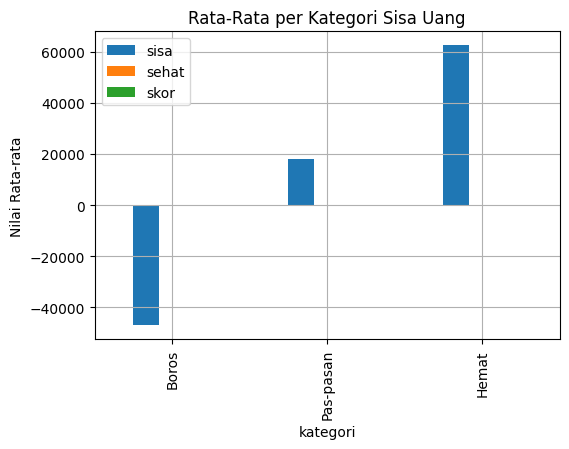

In [9]:
# === RINGKASAN RATA-RATA PER KATEGORI SISA ===
import numpy as np
import pandas as pd

# Buat dataframe ringkas
df_ringkas = pd.DataFrame({
    'sisa': sisa,
    'sehat': sehat,
    'skor': skor
})

# Definisikan ambang batas kategori yang masuk akal
AMBANG_PASPASAN = 50_000  # antara 0 dan 50 ribu dianggap pas-pasan

# Kelompokkan sisa uang menjadi kategori
df_ringkas['kategori'] = pd.cut(
    df_ringkas['sisa'],
    bins=[-np.inf, 0, AMBANG_PASPASAN, np.inf],
    labels=['Boros', 'Pas-pasan', 'Hemat'],
    include_lowest=True
)

# Cek jumlah sampel tiap kategori
print("\n[JUMLAH DATA PER KATEGORI]")
print(df_ringkas['kategori'].value_counts().reindex(['Boros', 'Pas-pasan', 'Hemat'], fill_value=0))

# Hitung rata-rata tiap kategori
ringkasan = df_ringkas.groupby('kategori')[['sisa', 'sehat', 'skor']].mean().round(2)
print("\n[RINGKASAN RATA-RATA PER KATEGORI SISA]")
print(ringkasan)

ringkasan.plot(kind='bar', figsize=(6,4), title='Rata-Rata per Kategori Sisa Uang', grid=True)
plt.ylabel('Nilai Rata-rata')
plt.show()

Penjelasan : Pada hasil 'JUMLAH DATA PER KATEGORI' didapatkan data responden ke dalam tiga kategori keuangan, yaitu :

a. Boros: 417 orang

b. Pas-pasan: 79 orang

c. Hemat: 4 orang

Hal ini menunjukkan bahwa sebagian besar responden tergolong boros, karena banyak yang menghabiskan uang melebihi anggaran Rp1.000.000 per bulan

Sedangkan pada hasil 'RINGKASAN RATA-RATA PER KATEGORI SISA' didapatkan :

a. Kelompok Boros punya nilai kesehatan dan total skor paling tinggi (11,10 dan 105,11).
Artinya, mereka sering memilih makanan yang sehat dan bervariasi, tapi harganya mahal, jadi uang mereka sering habis bahkan bisa minus.

b. Kelompok Pas-pasan bisa dibilang paling seimbang.
Mereka masih bisa makan makanan yang cukup sehat (skor 9,48), tapi uangnya juga masih tersisa. Jadi kelompok ini paling ideal dalam mengatur pengeluaran dan pola makan.

c. Kelompok Hemat memang punya sisa uang paling banyak (Rp62.500), tapi nilai kesehatannya paling rendah (8,90).
Kemungkinan karena mereka lebih sering pilih makanan murah, jadi gizinya tidak sebaik kelompok lain.

Pertanyaan : kenapa di visualisasi hanya ada warna biru?

Jawbaan : Jadi intinya, warna biru saja muncul karena “sisa uang” nilainya jauh lebih besar dari kolom lain,
jadi kolom sehat dan skor ketutupan skalanya.

Pertanyaan : buat agar semua nilai terlihat pda visualisasi ya

Jawaban : Oke, biar semua nilai (sisa, sehat, dan skor) terlihat jelas di satu visual, kita bisa bikin visualisasi kombinasi bar + garis dengan dua sumbu (dual-axis plot).

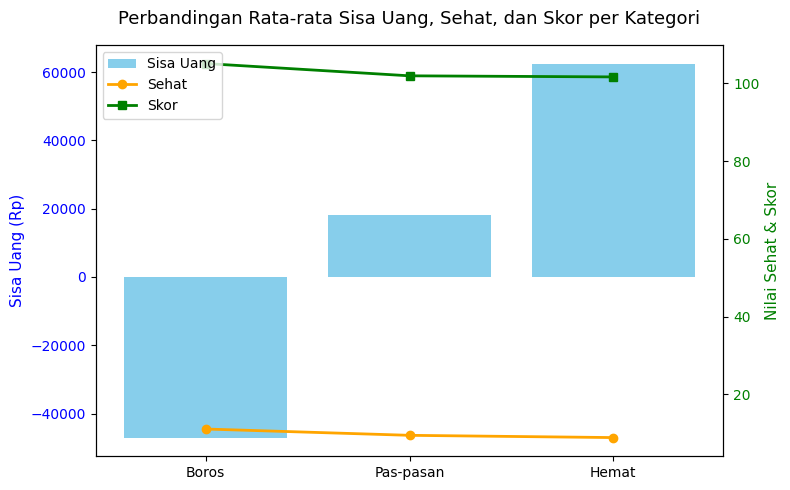

In [10]:
import matplotlib.pyplot as plt

# === PLOT KOMBINASI BAR + GARIS (DUAL AXIS) ===
fig, ax1 = plt.subplots(figsize=(8,5))

# Sumbu kiri (biru) untuk 'sisa uang'
ax1.bar(ringkasan.index, ringkasan['sisa'], color='skyblue', label='Sisa Uang')
ax1.set_ylabel('Sisa Uang (Rp)', color='blue', fontsize=11)
ax1.tick_params(axis='y', labelcolor='blue')

# Sumbu kanan (oranye & hijau) untuk 'sehat' dan 'skor'
ax2 = ax1.twinx()
ax2.plot(ringkasan.index, ringkasan['sehat'], color='orange', marker='o', linewidth=2, label='Sehat')
ax2.plot(ringkasan.index, ringkasan['skor'], color='green', marker='s', linewidth=2, label='Skor')
ax2.set_ylabel('Nilai Sehat & Skor', color='green', fontsize=11)
ax2.tick_params(axis='y', labelcolor='green')

# Tambahan elemen agar lebih informatif
plt.title("Perbandingan Rata-rata Sisa Uang, Sehat, dan Skor per Kategori", fontsize=13, pad=15)
fig.tight_layout()

# Gabungkan legend dari dua sumbu
lns1, lbls1 = ax1.get_legend_handles_labels()
lns2, lbls2 = ax2.get_legend_handles_labels()
ax2.legend(lns1 + lns2, lbls1 + lbls2, loc='upper left', frameon=True)

plt.show()


Pertanyaan : Bagaimana cara membaca visualisasinya?

Jawaban :
Cara membaca Grafik

1.Batang biru (bar) menunjukkan rata-rata sisa uang setelah 31 hari

a. Kalau batangnya tinggi ke atas, artinya responden masih punya sisa uang (hemat).

b. Kalau batangnya ke bawah, artinya uangnya habis atau defisit (boros)


2.Garis oranye (lingkaran) menunjukkan rata-rata skor kesehatan.

a. Semakin tinggi garis oranye, artinya responden memilih makanan yang lebih sehat.

3.Garis hijau (kotak) menunjukkan rata-rata skor total.

a. Skor ini gabungan dari rasa, kenyang, sehat, dan bosan.

b. Semakin tinggi, berarti pola makan secara keseluruhan lebih baik (meskipun belum tentu hemat).

Pertanyaan : Ada visualisasi yang lain?

Jawaban : Bisa banget! Selain “bar + garis (dual-axis)”, ada beberapa visual yang lebih gampang dibaca dan menghindari masalah perbedaan skala.

1. Bar chart asli: menampilkan tiga metrik bersama (seperti sebelumnya).

2. Small multiples: pisahkan jadi 3 panel agar tiap variabel jelas.

3. Normalisasi 0–1: semua skala disetarakan supaya bisa dibandingkan langsung.

4. Bubble chart: menggambarkan hubungan antara sisa dan sehat dengan ukuran gelembung = skor.

5. Lollipop chart: variasi dari bar chart yang lebih minimalis dan mudah dibaca.

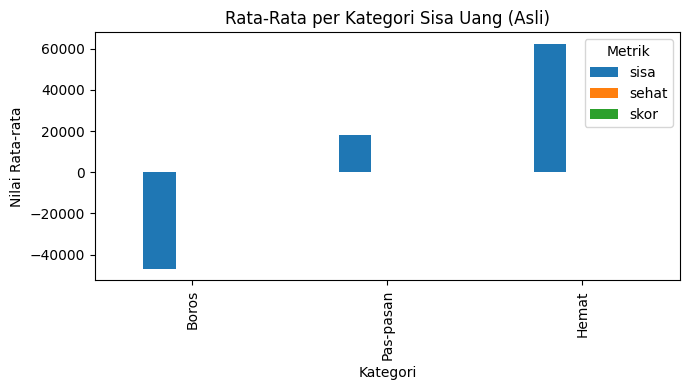

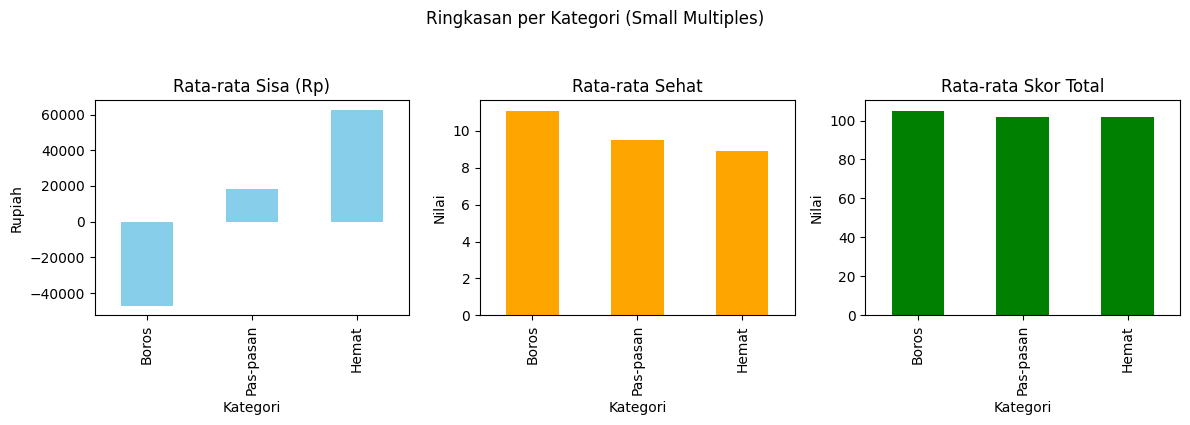

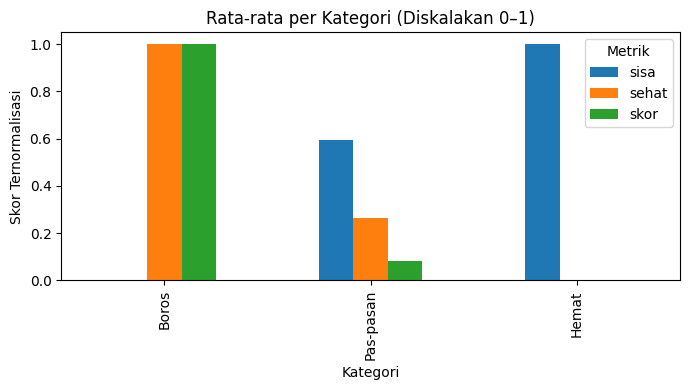

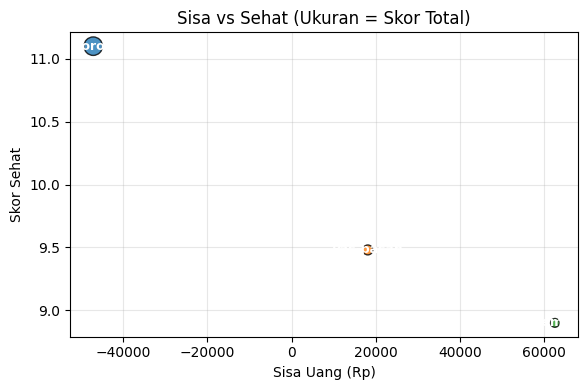

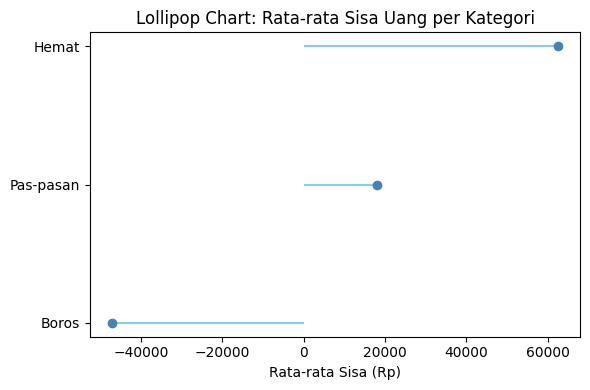

In [11]:
# === VISUALISASI GABUNGAN ===
import matplotlib.pyplot as plt
import numpy as np

# --- 1) Bar chart (original) ---
ringkasan.plot(kind='bar', figsize=(7,4))
plt.title('Rata-Rata per Kategori Sisa Uang (Asli)')
plt.ylabel('Nilai Rata-rata')
plt.xlabel('Kategori')
plt.legend(title='Metrik')
plt.tight_layout()
plt.show()

# --- 2) Small multiples (3 panel) ---
fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True)

ringkasan['sisa'].plot(kind='bar', ax=axes[0], color='skyblue', title='Rata-rata Sisa (Rp)')
axes[0].set_xlabel('Kategori'); axes[0].set_ylabel('Rupiah')

ringkasan['sehat'].plot(kind='bar', ax=axes[1], color='orange', title='Rata-rata Sehat')
axes[1].set_xlabel('Kategori'); axes[1].set_ylabel('Nilai')

ringkasan['skor'].plot(kind='bar', ax=axes[2], color='green', title='Rata-rata Skor Total')
axes[2].set_xlabel('Kategori'); axes[2].set_ylabel('Nilai')

plt.suptitle('Ringkasan per Kategori (Small Multiples)', y=1.05)
plt.tight_layout()
plt.show()

# --- 3) Normalisasi 0–1 untuk perbandingan ---
norm = (ringkasan - ringkasan.min()) / (ringkasan.max() - ringkasan.min())
norm.plot(kind='bar', figsize=(7,4))
plt.title('Rata-rata per Kategori (Diskalakan 0–1)')
plt.ylabel('Skor Ternormalisasi')
plt.xlabel('Kategori')
plt.legend(title='Metrik')
plt.tight_layout()
plt.show()

# --- 4) Bubble chart ---
x = ringkasan['sisa'].values
y = ringkasan['sehat'].values
size = (ringkasan['skor'].values - ringkasan['skor'].min() + 1) * 40
colors = {'Boros':'#1f77b4','Pas-pasan':'#ff7f0e','Hemat':'#2ca02c'}
c = [colors[k] for k in ringkasan.index]

plt.figure(figsize=(6,4))
plt.scatter(x, y, s=size, c=c, alpha=0.8, edgecolor='k')
for i, lbl in enumerate(ringkasan.index):
    plt.text(x[i], y[i], lbl, ha='center', va='center', color='white', fontsize=9, weight='bold')
plt.title('Sisa vs Sehat (Ukuran = Skor Total)')
plt.xlabel('Sisa Uang (Rp)'); plt.ylabel('Skor Sehat')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 5) Lollipop chart ---
cats = ringkasan.index
y = ringkasan['sisa'].values

plt.figure(figsize=(6,4))
plt.hlines(cats, xmin=0, xmax=y, colors='skyblue')
plt.plot(y, cats, 'o', color='steelblue')
plt.title('Lollipop Chart: Rata-rata Sisa Uang per Kategori')
plt.xlabel('Rata-rata Sisa (Rp)')
plt.tight_layout()
plt.show()
